In [20]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Custom KMeans class has been created, and can now be used for clustering
src_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(src_path)
from kmeans import CustomKMeans, plot_clusters

# Import the cleaned data for use in the project
cleaned_data_path = os.path.abspath(os.path.join('..', 'data', 'cleaned', 'car_prices_cleaned.csv'))
car_df = pd.read_csv(cleaned_data_path)
car_df.head(5)
car_df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

Possible Observations (Observations 1-2 Patrick B):

Observation 1: Why do some cars with identical attributes sell for significantly different prices?

Hypotheses:
The sellers could be located in different regions with varying demand or pricing trends.
One car might have additional features, trim upgrades, or warranties that weren’t recorded in the dataset.
Price discrepancies could result from negotiation differences or auction dynamics.

Observation 2: Why are there cars with extremely high condition ratings (for example 4.9 or 5.0) but very low prices? 
Hypotheses:
These could be compact or economy cars, which generally have lower market prices despite excellent condition.
The condition score might be subjective or inflated, not reflecting the actual value.
There might have been a mistake in recording the selling price.

Significant Price Differences in Identical Groups:
        year      make           model  condition  odometer  count  min_price  \
191511  2011      Ford           F-150        4.0  103926.0      2       9800   
338913  2013      Ford           F-150        4.8   24150.0      2      16400   
406043  2014  Chrysler             200        4.4   23698.0      2      11500   
435783  2014   Hyundai  Santa Fe Sport        5.0      10.0      2      13200   
468565  2015      Jeep        Wrangler        4.0       5.0      2      18200   

        max_price  price_range  
191511      21400        11600  
338913      27000        10600  
406043      31000        19500  
435783      27900        14700  
468565      35200        17000  
Cars with Significant Price Differences Despite Identical Attributes:
   year      make           model              trim       body transmission  \
0  2014  Chrysler             200           Touring      Sedan    automatic   
1  2015      Jeep        Wrangler  U

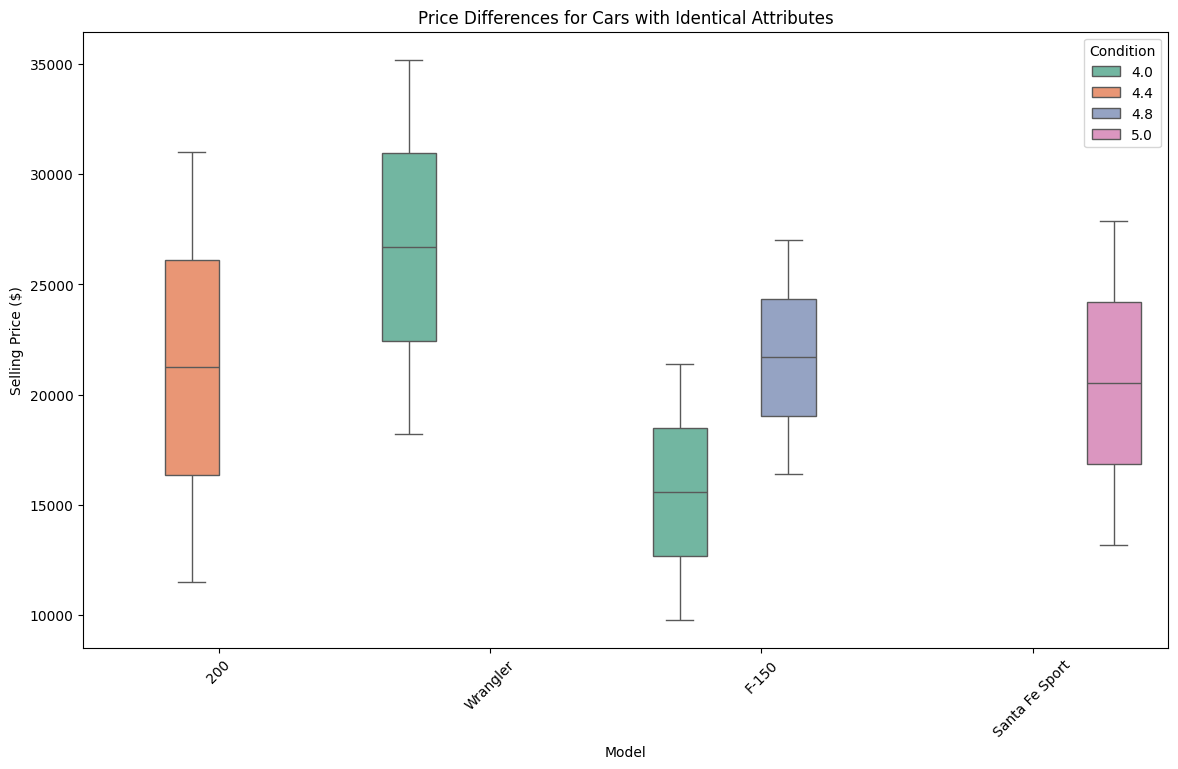

In [ ]:
#Observation 1 Differences in Cars with the Same Attributes:

# Group Cars by year, odometer, condition, make, and model
key_attributes = ['year', 'make', 'model', 'condition', 'odometer']
grouped = car_df.groupby(key_attributes).agg(
    count=('sellingprice', 'size'),
    min_price=('sellingprice', 'min'),
    max_price=('sellingprice', 'max'),
    price_range=('sellingprice', lambda x: x.max() - x.min())
).reset_index()

price_difference_threshold = 10000  # Set a significant price difference
significant_differences = grouped[grouped['price_range'] > price_difference_threshold]

print("Significant Price Differences in Identical Groups:")
print(significant_differences)

#This DataFrame contains the actual cars from the dataframe 
#that belong to the groups identified in significant_differences
significant_groups = car_df.merge(
    significant_differences[key_attributes],
    on=key_attributes,
    how='inner'
)

print("Cars with Significant Price Differences Despite Identical Attributes:")
print(significant_groups)

#Box plot of the findings
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=significant_groups,
    x='model',
    y='sellingprice',
    hue='condition',
    palette='Set2'
)
plt.title('Price Differences for Cars with Identical Attributes')
plt.xlabel('Model')
plt.ylabel('Selling Price ($)')
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.show()

I investigated cars with the same attributes such as year, make, model, condition, and odometer that showcased substantial differences in the pricing. The dataset was grouped based on these key attributes. The analysis showcased cars with identical or near-identical attributes but significat differences in the price. For example:
* A 2014 Chrysler 200 with 23,698 miles and condition 4.4 had a price range from $11,500 to $31,000, a difference of $19,500.
* A 2013 Ford F-150, condition 4.8, with only 24,150 miles had a price range of $10,600, ranging from $16,400 to $27,000.

The main explination for this seems to be the differences in trim levels, as well as the possible demand in those regions.

# Toyota Camry popularity predicts an increase in the popularity of other models

In [4]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

fordpickup = os.path.abspath(os.path.join('..', 'data', 'raw', 'google_trends', 'ford_pickup.csv'))
camry = os.path.abspath(os.path.join('..', 'data', 'raw', 'google_trends', 'toyota_camry.csv'))
altima = os.path.abspath(os.path.join('..', 'data', 'raw', 'google_trends', 'nissan_altima.csv'))

onefifty_df = pd.read_csv(fordpickup)
camry_df = pd.read_csv(camry)
altima_df = pd.read_csv(altima) 

In [5]:
# Reset the index for each DataFrame to make the 'Week' column accessible
onefifty_df_reset = onefifty_df.reset_index()
camry_df_reset = camry_df.reset_index()
altima_df_reset = altima_df.reset_index()

# The first column is the 'Week' column. Rename it to 'date' for clarity.
onefifty_df_reset.columns = ['date', 'popularity']
camry_df_reset.columns = ['date', 'popularity']
altima_df_reset.columns = ['date', 'popularity']

# Ensure that the 'date' column contains only the date information, and strip any leading/trailing whitespace
onefifty_df_reset['date'] = onefifty_df_reset['date'].str.replace('Week', '').str.strip()
camry_df_reset['date'] = camry_df_reset['date'].str.replace('Week', '').str.strip()
altima_df_reset['date'] = altima_df_reset['date'].str.replace('Week', '').str.strip()

# Convert the 'date' column to datetime format
onefifty_df_reset['date'] = pd.to_datetime(onefifty_df_reset['date'])
camry_df_reset['date'] = pd.to_datetime(camry_df_reset['date'])
altima_df_reset['date'] = pd.to_datetime(altima_df_reset['date'])

# Print the updated DataFrames to verify the changes
print("Ford F-150 DataFrame:\n", onefifty_df_reset.head())
print("Toyota Camry DataFrame:\n", camry_df_reset.head())
print("Nissan Altima DataFrame:\n", altima_df_reset.head())


Ford F-150 DataFrame:
         date                   popularity
0        NaT  Ford F-150: (United States)
1 2013-12-29                           59
2 2014-01-05                           55
3 2014-01-12                          100
4 2014-01-19                           66
Toyota Camry DataFrame:
         date                     popularity
0        NaT  Toyota Camry: (United States)
1 2013-12-29                             63
2 2014-01-05                             59
3 2014-01-12                             60
4 2014-01-19                             58
Nissan Altima DataFrame:
         date                      popularity
0        NaT  Nissan Altima: (United States)
1 2013-12-29                              80
2 2014-01-05                              79
3 2014-01-12                              80
4 2014-01-19                              80


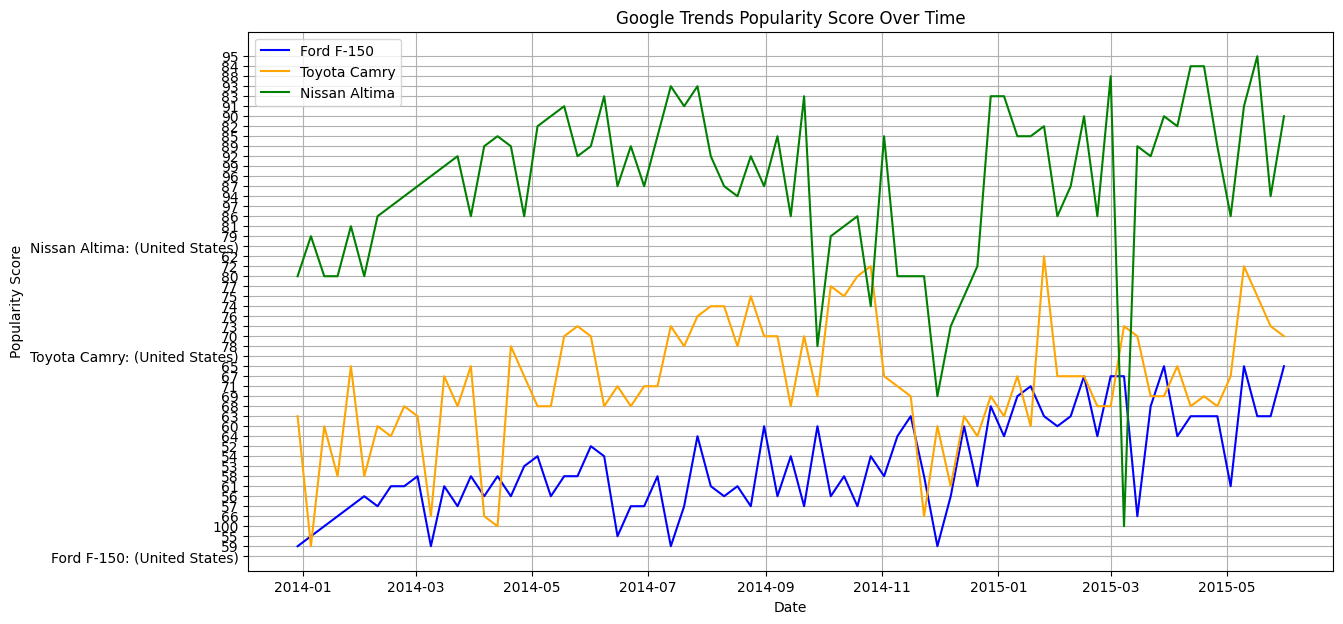

In [6]:
#Data looks okay, we can move forward with plotting
plt.figure(figsize=(14, 7))

plt.plot(onefifty_df_reset['date'], onefifty_df_reset['popularity'], label='Ford F-150', color='blue')
plt.plot(camry_df_reset['date'], camry_df_reset['popularity'], label='Toyota Camry', color='orange')
plt.plot(altima_df_reset['date'], altima_df_reset['popularity'], label='Nissan Altima', color='green')

plt.title('Google Trends Popularity Score Over Time')
plt.xlabel('Date')
plt.ylabel('Popularity Score')
plt.legend()
plt.grid()

plt.show()

In [40]:
cleaned_data_path = os.path.abspath(os.path.join('..', 'data', 'cleaned', 'car_prices_cleaned.csv'))
car_df = pd.read_csv(cleaned_data_path)
car_df.head(5)
car_df.columns


Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

C:\Users\xxway\AppData\Local\Temp\ipykernel_11632\444730064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['saledate'] = pd.to_datetime(filtered_data['saledate'])
C:\Users\xxway\AppData\Local\Temp\ipykernel_11632\444730064.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_2015['month'] = filtered_2015['saledate'].dt.month
C:\Users\xxway\AppData\Local\Temp\ipykernel_11632\444730064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

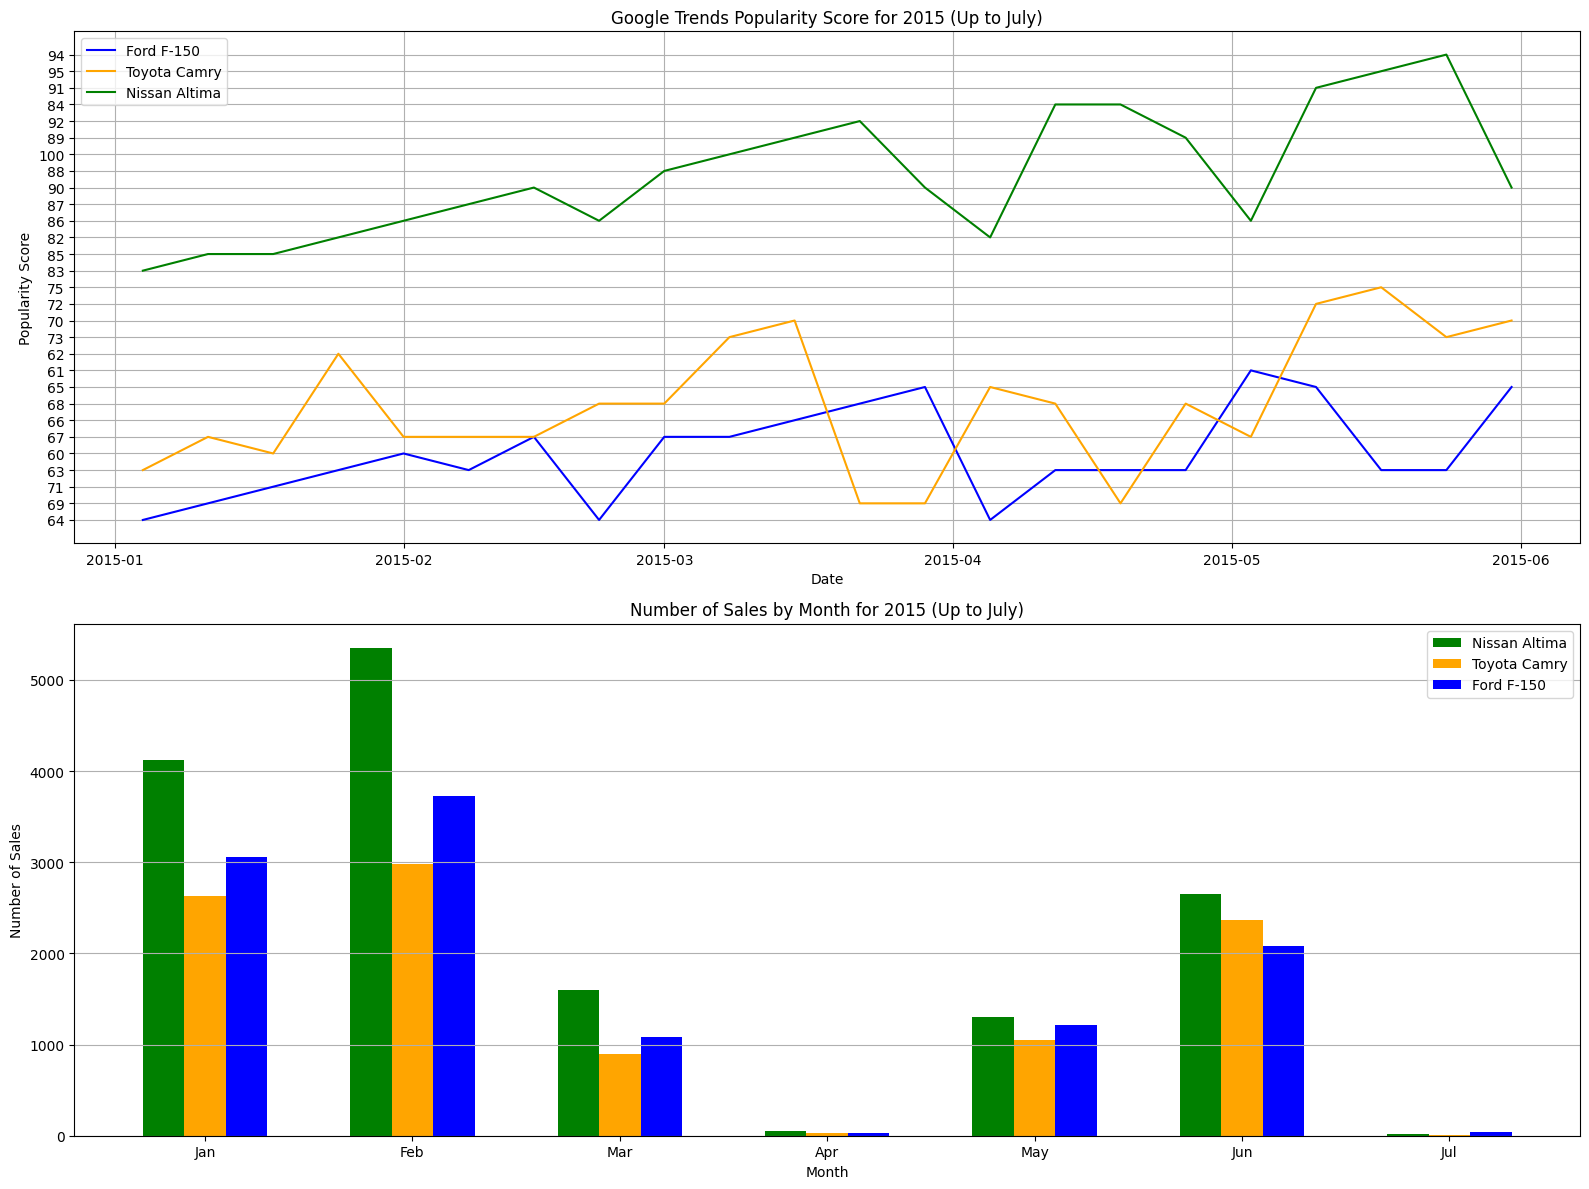

In [41]:
onefifty_2015 = onefifty_df_reset[(onefifty_df_reset['date'].dt.year == 2015) & (onefifty_df_reset['date'].dt.month <= 7)]
camry_2015 = camry_df_reset[(camry_df_reset['date'].dt.year == 2015) & (camry_df_reset['date'].dt.month <= 7)]
altima_trends_2015 = altima_df_reset[(altima_df_reset['date'].dt.year == 2015) & (altima_df_reset['date'].dt.month <= 7)]

# Function to filter and aggregate sales data up to July 2015
def get_sales_data(car_df, make, model):
    filtered_data = car_df[(car_df['make'].str.lower() == make) & (car_df['model'].str.lower() == model)]
    filtered_data['saledate'] = pd.to_datetime(filtered_data['saledate'])
    filtered_2015 = filtered_data[(filtered_data['saledate'].dt.year == 2015) & (filtered_data['saledate'].dt.month <= 7)]
    filtered_2015['month'] = filtered_2015['saledate'].dt.month
    monthly_sales = filtered_2015.groupby('month')['sellingprice'].count().reset_index()
    monthly_sales.rename(columns={'sellingprice': 'count'}, inplace=True)
    return monthly_sales

# Get sales data for the three cars
altima_sales_2015 = get_sales_data(car_df, 'nissan', 'altima')
camry_sales_2015 = get_sales_data(car_df, 'toyota', 'camry')
f150_sales_2015 = get_sales_data(car_df, 'ford', 'f-150')

# Plotting
plt.figure(figsize=(16, 12))

# Google Trends Popularity Plot
plt.subplot(2, 1, 1)
plt.plot(onefifty_2015['date'], onefifty_2015['popularity'], label='Ford F-150', color='blue')
plt.plot(camry_2015['date'], camry_2015['popularity'], label='Toyota Camry', color='orange')
plt.plot(altima_trends_2015['date'], altima_trends_2015['popularity'], label='Nissan Altima', color='green')
plt.title('Google Trends Popularity Score for 2015 (Up to July)')
plt.xlabel('Date')
plt.ylabel('Popularity Score')
plt.legend()
plt.grid()

# Car Sales Plot
plt.subplot(2, 1, 2)
plt.bar(altima_sales_2015['month'] - 0.2, altima_sales_2015['count'], width=0.2, label='Nissan Altima', color='green')
plt.bar(camry_sales_2015['month'], camry_sales_2015['count'], width=0.2, label='Toyota Camry', color='orange')
plt.bar(f150_sales_2015['month'] + 0.2, f150_sales_2015['count'], width=0.2, label='Ford F-150', color='blue')
plt.title('Number of Sales by Month for 2015 (Up to July)')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.xticks(ticks=range(1, 8), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Observation:
The Nissan Altima showed a sudden spike in Google Trends popularity in May, but this did not correspond to a similar increase in sales.

Hypothesis:
The May popularity spike could have been driven by non-purchase-related events, such as a prominent marketing campaign, a recall, or media coverage.

The steps I took to further investigate this were to look at real life campaigns and marketing to see if there was anything special anout May 2015 for Nissan Altima's.

I found many references to the Nissan "Ride of Your Life" campaign. I found this to be interesting but wondered why this did not correlate directly to an increase in sales. The data frame we have is very large so it would have not made much sense that we did not have enough data. However after further examination, the data frame lacked in data between March and May. and while I could not find anythign in particular as to why this may have occured, my assumptions boil down to two reasons. Lack of Data, there is simply not enough data. Or those summer months people tend to buy New cars instead of used cars.

I then examined the google trends data for "New Cars" search queries and found that the lowest index was in April which might indicate a general disinterest in purchasing cars in general